## Introduction
##### How to get started with topic modeling using LDA in Python
** **
Topic Models, in a nutshell, are a type of statistical language models used for uncovering hidden structure in a collection of texts. In a practical and more intuitively, you can think of it as a task of:

- **Dimensionality Reduction**, where rather than representing a text T in its feature space as {Word_i: count(Word_i, T) for Word_i in Vocabulary}, you can represent it in a topic space as {Topic_i: Weight(Topic_i, T) for Topic_i in Topics}
- **Unsupervised Learning**, where it can be compared to clustering, as in the case of clustering, the number of topics, like the number of clusters, is an output parameter. By doing topic modeling, we build clusters of words rather than clusters of texts. A text is thus a mixture of all the topics, each having a specific weight
- **Tagging**, abstract “topics” that occur in a collection of documents that best represents the information in them.

There are several existing algorithms you can use to perform the topic modeling. The most common of it are, Latent Semantic Analysis (LSA/LSI), Probabilistic Latent Semantic Analysis (pLSA), and Latent Dirichlet Allocation (LDA)

In this tutorial, we’ll take a closer look at LDA, and implement our first topic model using the sklearn implementation in python 2.7

### Theoretical Overview
LDA is a generative probabilistic model that assumes each topic is a mixture over an underlying set of words, and each document is a mixture of over a set of topic probabilities.

![LDA_Model](https://github.com/chdoig/pytexas2015-topic-modeling/blob/master/images/lda-4.png?raw=true)

We can describe the generative process of LDA as, given the M number of documents, N number of words, and prior K number of topics, the model trains to output:

- `psi`, the distribution of words for each topic K
- `phi`, the distribution of topics for each document i

#### Parameters of LDA

- `Alpha parameter` is Dirichlet prior concentration parameter that represents document-topic density — with a higher alpha, documents are assumed to be made up of more topics and result in more specific topic distribution per document.
- `Beta parameter` is the same prior concentration parameter that represents topic-word density — with high beta, topics are assumed to made of up most of the words and result in a more specific word distribution per topic.

**To read more: https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0**

** **
### LDA Implementation

1. [Loading data](#load_data)
2. [Data cleaning](#clean_data)
3. [Exploratory analysis](#eda)
4. [Prepare data for LDA analysis](#data_preparation)
5. [LDA model training](#train_model)
6. [Analyzing LDA model results](#results)

** **
For this tutorial, we’ll use the dataset of papers published in NeurIPS (NIPS) conference which is one of the most prestigious yearly events in the machine learning community. The CSV data file contains information on the different NeurIPS papers that were published from 1987 until 2016 (29 years!). These papers discuss a wide variety of topics in machine learning, from neural networks to optimization methods, and many more.

<img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_158/img/nips_logo.png" alt="The logo of NIPS (Neural Information Processing Systems)">

Let’s start by looking at the content of the file

** **
#### Step 1: Loading Data <a class="anchor\" id="load_data"></a>
** **
For this tutorial, we’ll use the dataset of papers published in NeurIPS (NIPS) conference which is one of the most prestigious yearly events in the machine learning community. The CSV data file contains information on the different NeurIPS papers that were published from 1987 until 2016 (29 years!). These papers discuss a wide variety of topics in machine learning, from neural networks to optimization methods, and many more.

Let’s start by looking at the content of the file

In [7]:
import zipfile
import pandas as pd
import os

# Open the zip file
with zipfile.ZipFile("./NIPS Papers.zip", "r") as zip_ref:
    # Extract the file to a temporary directory
    zip_ref.extractall("temp")

# Read the CSV file into a pandas DataFrame
papers = pd.read_csv("temp/NIPS Papers/papers.csv")

# Print head
papers.head()

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


** **
#### Step 2: Data Cleaning <a class="anchor\" id="clean_data"></a>
** **

Since the goal of this analysis is to perform topic modeling, let's focus only on the text data from each paper, and drop other metadata columns. Also, for the demonstration, we'll only look at 100 papers

In [9]:
# Remove the columns
papers = papers.drop(columns=['id', 'event_type', 'pdf_name'], axis=1).sample(100)

# Print out the first rows of papers
papers.head()

,year,title,abstract,paper_text
1546,2003,Classification with Hybrid Generative/Discrimi...,Abstract Missing,Classification with Hybrid\nGenerative/Discrim...
5830,2016,Ladder Variational Autoencoders,Variational autoencoders are powerful models f...,Ladder Variational Autoencoders\nCasper Kaae S...
2438,2007,Using Deep Belief Nets to Learn Covariance Ker...,We show how to use unlabeled data and a deep b...,Using Deep Belief Nets to Learn Covariance Ker...
605,1998,Direct Optimization of Margins Improves Genera...,Abstract Missing,Direct Optimization of Margins Improves\nGener...
1566,2003,Probabilistic Inference in Human Sensorimotor ...,Abstract Missing,Probabilistic Inference in Human Sensorimotor\...


##### Remove punctuation/lower casing

Next, let’s perform a simple preprocessing on the content of `paper_text` column to make them more amenable for analysis, and reliable results. To do that, we’ll use a regular expression to remove any punctuation, and then lowercase the text

In [11]:
# Load the regular expression library
import re

# Remove punctuation
papers['paper_text_processed'] = \
papers['paper_text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
papers['paper_text_processed'] = \
papers['paper_text_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
papers['paper_text_processed'].head()

<>:6: SyntaxWarning: invalid escape sequence '\.'
<>:6: SyntaxWarning: invalid escape sequence '\.'
/var/folders/hh/v5mfdbdn43z0n2v1mbb_yc_40000gn/T/ipykernel_36206/694571098.py:6: SyntaxWarning: invalid escape sequence '\.'
  papers['paper_text'].map(lambda x: re.sub('[,\.!?]', '', x))


1546    classification with hybrid\ngenerative/discrim...
5830    ladder variational autoencoders\ncasper kaae s...
2438    using deep belief nets to learn covariance ker...
605     direct optimization of margins improves\ngener...
1566    probabilistic inference in human sensorimotor\...
Name: paper_text_processed, dtype: object

** **
#### Step 3: Exploratory Analysis <a class="anchor\" id="eda"></a>
** **

To verify whether the preprocessing, we’ll make a simple word cloud using the `wordcloud` package to get a visual representation of most common words. It is key to understanding the data and ensuring we are on the right track, and if any more preprocessing is necessary before training the model.

In [13]:
!pip install wordcloud

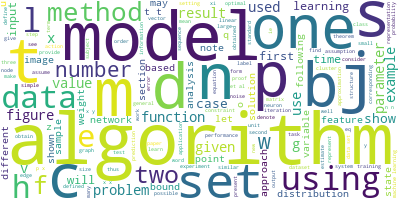

In [14]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(papers['paper_text_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

** **
#### Step 4: Prepare text for LDA analysis <a class="anchor\" id="data_preparation"></a>
** **

Next, let’s work to transform the textual data in a format that will serve as an input for training LDA model. We start by tokenizing the text and removing stopwords. Next, we convert the tokenized object into a corpus and dictionary.

In [16]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]


data = papers.paper_text_processed.values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

print(data_words[:1][0][:30])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ameeraattiah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['classification', 'hybrid', 'generative', 'discriminative', 'models', 'rajat', 'raina', 'yirong', 'shen', 'andrew', 'ng', 'computer', 'science', 'department', 'stanford', 'university', 'stanford', 'ca', 'andrew', 'mccallum', 'department', 'computer', 'science', 'university', 'massachusetts', 'amherst', 'abstract', 'although', 'trained', 'classifiers']


In [17]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 2), (3, 1), (4, 26), (5, 3), (6, 2), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 3), (17, 1), (18, 2), (19, 1), (20, 1), (21, 1), (22, 26), (23, 1), (24, 3), (25, 1), (26, 1), (27, 2), (28, 21), (29, 3)]


** **
#### Step 5: LDA model tranining <a class="anchor\" id="train_model"></a>
** **

To keep things simple, we'll keep all the parameters to default except for inputting the number of topics. For this tutorial, we will build a model with 10 topics where each topic is a combination of keywords, and each keyword contributes a certain weightage to the topic.

In [19]:
from pprint import pprint

# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.008*"model" + 0.006*"learning" + 0.005*"algorithm" + 0.005*"data" + '
  '0.004*"function" + 0.004*"set" + 0.004*"one" + 0.003*"using" + '
  '0.003*"distribution" + 0.003*"problem"'),
 (1,
  '0.007*"learning" + 0.007*"algorithm" + 0.007*"data" + 0.005*"model" + '
  '0.005*"set" + 0.004*"two" + 0.004*"distribution" + 0.003*"number" + '
  '0.003*"figure" + 0.003*"function"'),
 (2,
  '0.007*"data" + 0.006*"algorithm" + 0.005*"set" + 0.005*"learning" + '
  '0.004*"one" + 0.004*"using" + 0.004*"model" + 0.004*"function" + 0.004*"xi" '
  '+ 0.004*"matrix"'),
 (3,
  '0.008*"learning" + 0.007*"model" + 0.006*"set" + 0.005*"data" + '
  '0.005*"function" + 0.005*"algorithm" + 0.004*"one" + 0.004*"using" + '
  '0.003*"log" + 0.003*"distribution"'),
 (4,
  '0.006*"data" + 0.006*"learning" + 0.005*"algorithm" + 0.004*"set" + '
  '0.004*"model" + 0.004*"time" + 0.004*"information" + 0.003*"function" + '
  '0.003*"figure" + 0.003*"one"'),
 (5,
  '0.007*"data" + 0.006*"algorithm" + 0.006*"lea

** **
#### Step 6: Analyzing our LDA model <a class="anchor\" id="results"></a>
** **

Now that we have a trained model let’s visualize the topics for interpretability. To do so, we’ll use a popular visualization package, pyLDAvis which is designed to help interactively with:

1. Better understanding and interpreting individual topics, and
2. Better understanding the relationships between the topics.

For (1), you can manually select each topic to view its top most frequent and/or “relevant” terms, using different values of the λ parameter. This can help when you’re trying to assign a human interpretable name or “meaning” to each topic.

For (2), exploring the Intertopic Distance Plot can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics.

In [21]:
!pip install pyLDAvis

In [22]:
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(num_topics) +'.html')

LDAvis_prepared

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=36206) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=36206) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=36206) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=36206) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarnin

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.002738  0.003522       1        1  14.584285
4     -0.002627  0.000394       2        1  13.886867
7      0.005926 -0.007012       3        1  12.587654
3      0.008428  0.001651       4        1  11.349158
2     -0.003143 -0.003079       5        1  11.203144
0      0.003676  0.009387       6        1  11.010424
5     -0.009551  0.000692       7        1   8.064533
1     -0.001498 -0.001996       8        1   7.131847
8      0.003624 -0.001697       9        1   5.226581
9     -0.002097 -0.001863      10        1   4.955508, topic_info=              Term         Freq        Total Category  logprob  loglift
177           data  1399.000000  1399.000000  Default  30.0000  30.0000
414       learning  1499.000000  1499.000000  Default  29.0000  29.0000
472          model  1234.000000  1234.000000  Default  28.0000  28.0000
22       algorithm  1244.000000  1244.000000  Default  27.0000  27.0000
1393          time   695.000000   695.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
655        results    22.259296   470.720101  Topic10  -6.2205  -0.0468
430            log    22.386064   583.198286  Topic10  -6.2148  -0.2554
834             xi    22.118030   565.439609  Topic10  -6.2269  -0.2365
780       training    21.564600   520.353211  Topic10  -6.2522  -0.1788
215   distribution    21.755250   636.983198  Topic10  -6.2434  -0.3722

[879 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
5705      1  0.070615  accumulation
5705      2  0.141230  accumulation
5705      3  0.070615  accumulation
5705      4  0.211845  accumulation
5705      5  0.070615  accumulation
...     ...       ...           ...
2231      6  0.100981            yi
2231      7  0.079944            yi
2231      8  0.100981            yi
2231      9  0.054698            yi
2231     10  0.046283            yi

[3986 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 5, 8, 4, 3, 1, 6, 2, 9, 10])

** **
#### Closing Notes
Machine learning has become increasingly popular over the past decade, and recent advances in computational availability have led to exponential growth to people looking for ways how new methods can be incorporated to advance the field of Natural Language Processing.

Often, we treat topic models as black-box algorithms, but hopefully, this article addressed to shed light on the underlying math, and intuitions behind it, and high-level code to get you started with any textual data.

In the next article, we’ll go one step deeper into understanding how you can evaluate the performance of topic models, tune its hyper-parameters to get more intuitive and reliable results.

** **
#### References:
1. Topic model — Wikipedia. https://en.wikipedia.org/wiki/Topic_model
2. Distributed Strategies for Topic Modeling. https://www.ideals.illinois.edu/bitstream/handle/2142/46405/ParallelTopicModels.pdf?sequence=2&isAllowed=y
3. Topic Mapping — Software — Resources — Amaral Lab. https://amaral.northwestern.edu/resources/software/topic-mapping
4. A Survey of Topic Modeling in Text Mining. https://thesai.org/Downloads/Volume6No1/Paper_21-A_Survey_of_Topic_Modeling_in_Text_Mining.pdf
